# Data Preprocessing
- The Missing values are for sensor and it makes sense to fill them with zero,since filling the missing values with an acutal value might cause misleading.
- There are 6000 rows and 10 columns for each of the csv files within train and test folders. This amount of data needs reduction. I have performed PCA on the transposed version of the csv files. This process will change the 6000 x 10 csv file to 10 x 10 csv file.
- The PCA model is fitted on the first csv file of the train directory to keep the dimension reduction consistent on all the logs.

In [14]:
import numpy as np
import pandas as pd 


KAGGLE = False
base_path = '/kaggle/input/' if KAGGLE else './'

# Training data
train = pd.read_csv(f'{base_path}predict-volcanic-eruptions-ingv-oe/train.csv')
sample_submission = pd.read_csv(f'{base_path}predict-volcanic-eruptions-ingv-oe/sample_submission.csv')

# Getting the ids
train_ids = train['segment_id']
test_ids = sample_submission['segment_id']

# Value to be predicted
y = train['time_to_eruption']


# Measures of Central Tendency for raw data
X = np.load(f'{base_path}volcano-pca/train.npy')
X_test = np.load(f'{base_path}volcano-pca/test.npy')

# Measures of Central Tendency for rolling data
X_rolling = np.load(f'{base_path}volcano-pca/rolling_train.npy')
X_rolling_test = np.load(f'{base_path}volcano-pca/rolling_test.npy')

In [26]:
# Importing the needed utilities for NN
import tensorflow as tf
from tensorflow.keras import Model, Input, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, InputLayer, Concatenate, Add, SeparableConv2D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.initializers import TruncatedNormal

# Data Preprocessing/validation utilities
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold

# Importing the plotting utilities
from matplotlib import pyplot as plt

In [34]:
X_rolling[0].shape

(10, 16)

In [35]:
X[0].shape

(10, 16)

In [38]:
np.concatenate((X[0], X_rolling[0]), axis=1)

(10, 32)

# Modeling
They two possible input data for this competition, image-shaped input and tabularized version of the same image:
1. Image-shaped: The input is the measures of central tendency (mean, std, etc.) of each signal which is 10x16 dataframe for each id. These measures have been calculated on raw data and the rolling data. 
2. Tabular: The Tabular format is the reshaped version of the image format with omitted columns (This is not good for Neural network).

## CNN
CNNs could be used to find patterns between the measures of central tendencies:
- By tweaking stride values we can find patterns between signals (vertical) and measures (horizontal).
- Multilpe parallel CNNs can help to generalize the graph (widening).
- Consequtive CNNs + Fully connected layers can be used to depean the Network.

In [61]:
# The Global weight initializer
WInit = TruncatedNormal(0, 1, 111)

def concat_inputs(Inp1, Inp2): 
    """
        Concatenates the raw measures with rolling measures
        
        input:
            Inp1: input1
            Inp2: input2
        return:
            Concatenated version of the two inputs
    """
    return Concatenate(axis=2)([In1, In2])
    
def fc(Inp, unit=100, n=3, activation='relu'):
    """
        Fully Connected layer used on the flattened data
        
        input:
            Inp: Input data
            unit: Number of units
            n: Number of hidden layers
            activation: activation function used in layers
        
        return:
            returning the tensor after processed by the fully connected layer
    """
    Inp = Flatten()(Inp)
    out = BatchNormalization()(Dense(unit, activation=activation ,kernel_initializer=WInit)(Inp))
    for i in range(0, n-1): out = BatchNormalization()(Dense(unit, activation=activation ,kernel_initializer=WInit)(out))
        
        
    out = Dense(1, kernel_initializer=TruncatedNormal(10, 1e-1, 11))(out)
        
    return out

# Sub-model/layers
Each of them has 3 parts:
1. Convulotional
2. Fully Connected
3. Prediction

In [57]:
def conv1(Inp, unit=64):
    c = SeparableConv2D(unit, (10, 10),  kernel_initializer=WInit)(Inp)
    c = SeparableConv2D(unit, (1, 3),  kernel_initializer=WInit)(c)
    return c

def conv2(Inp, unit=64):
    c = SeparableConv2D(unit, (1, 5),  kernel_initializer=WInit)(Inp)
    c = SeparableConv2D(unit, (1, 3),  kernel_initializer=WInit)(c)
    
    return c

def conv3(Inp, unit=32):
    c = SeparableConv2D(unit, (1, 10),  kernel_initializer=WInit)(Inp)
    
    c1 = SeparableConv2D(unit, (3, 1),  kernel_initializer=WInit)(c)
    c1 = SeparableConv2D(unit, (1, 3),  kernel_initializer=WInit)(c1)
    
    c2 = SeparableConv2D(unit, (1, 3),  kernel_initializer=WInit)(c)
    c2 = SeparableConv2D(unit, (3, 1),  kernel_initializer=WInit)(c2)
    
    return c1, c2, Concatenate()([c1, c2])

def conv4(Inp, unit=64):
    c = SeparableConv2D(unit, (10, 1),  kernel_initializer=WInit)(Inp)
    c = SeparableConv2D(unit, (1, 3),  kernel_initializer=WInit)(c)
    return c

In [69]:
def model1(Inp):
    c1 = conv1(Inp)
    c2 = conv2(Inp)
    c31, c32, c3c = conv3(Inp)
    c4 = conv4(Inp)
    
    preds = [fc(Inp) for Inp in [c1, c2, c31, c32, c3c, c4]]
    
    out = Concatenate()(preds)
    
    out = Dense(1, kernel_initializer=TruncatedNormal(10, 1e-1, 11))(out)
        
    return out

In [70]:
# Input
In1 = Input(shape=(10,16,1))
# In2 = Input(shape=(10,16,1))

m1 = model(In1)
# m2 = model(In2)

model = Model(inputs=[In1], outputs=[m1])

In [71]:
model.count_params() / 1e6

1.42145

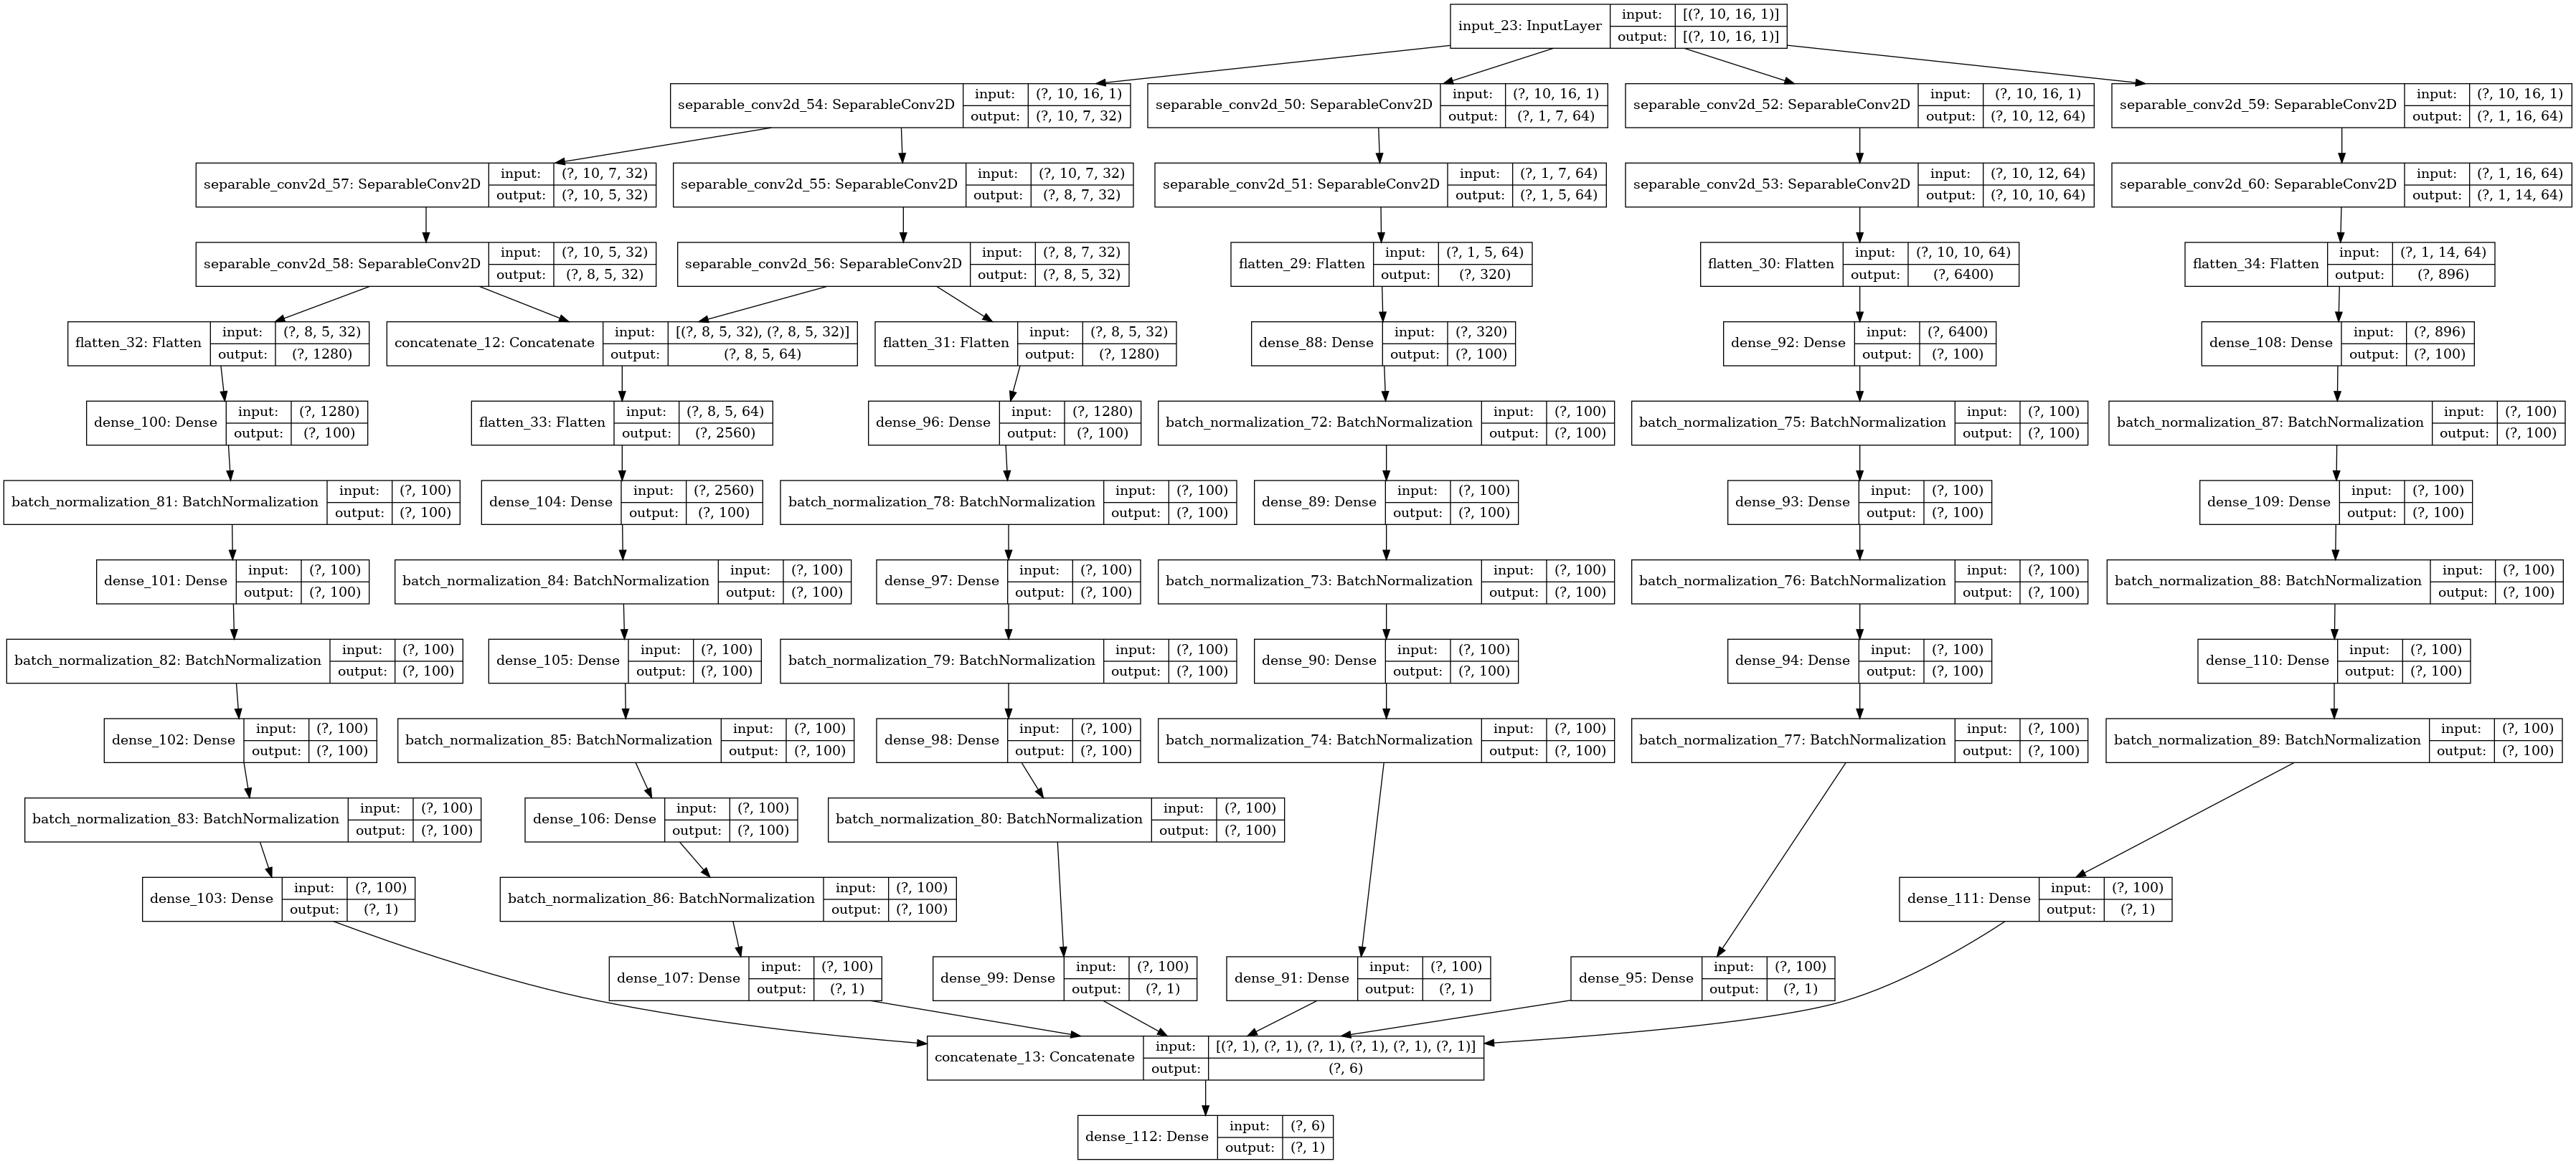

In [72]:
plot_model(model, show_layer_names=1, show_shapes=1)

In [50]:
WInit((64,1))[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.36231187],
       [ 0.18865405],
       [-0.31605548],
       [-0.99769825],
       [ 0.85163224],
       [ 0.5310765 ],
       [ 0.6461512 ],
       [ 0.37571266],
       [ 0.09399657],
       [-1.3879474 ]], dtype=float32)>

In [78]:
model.get_layer(name="1").get_weights()[0][:10]

array([[ 0.4288704 ],
       [ 0.41750592],
       [-0.5681576 ],
       [-1.2357936 ],
       [ 1.1013372 ],
       [ 0.7799373 ],
       [ 0.8451439 ],
       [ 0.5826395 ],
       [ 0.33655828],
       [-1.6329556 ]], dtype=float32)

In [ ]:
model.compile(optimizer=Adam(0.0015), loss='mae',)

hist = model.fit([X], y, epochs= 50, batch_size=128,
                 callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.9, patience=10, verbose=1, min_lr=0)],
                  verbose=True,
#                   validation_split=0.33,
                  shuffle=True) 

Epoch 1/50
35/35 [==============================] - 3s 76ms/step - loss: 22847300.0000
Epoch 2/50
35/35 [==============================] - 3s 75ms/step - loss: 22844068.0000
Epoch 3/50
35/35 [==============================] - 3s 75ms/step - loss: 22840702.0000
Epoch 4/50
35/35 [==============================] - 3s 75ms/step - loss: 22837210.0000
Epoch 5/50
35/35 [==============================] - 3s 75ms/step - loss: 22833562.0000
Epoch 6/50
35/35 [==============================] - 3s 76ms/step - loss: 22829776.0000
Epoch 7/50
35/35 [==============================] - 3s 76ms/step - loss: 22825846.0000
Epoch 8/50
35/35 [==============================] - 3s 75ms/step - loss: 22821756.0000
Epoch 9/50
35/35 [==============================] - 3s 75ms/step - loss: 22817520.0000
Epoch 10/50
35/35 [==============================] - 3s 76ms/step - loss: 22813136.0000
Epoch 11/50
35/35 [==============================] - 3s 82ms/step - loss: 22808584.0000
Epoch 12/50
35/35 [======================

In [31]:
v= pd.DataFrame(hist.history)
v['loss'] /= 4
v['val_loss'] /= 4

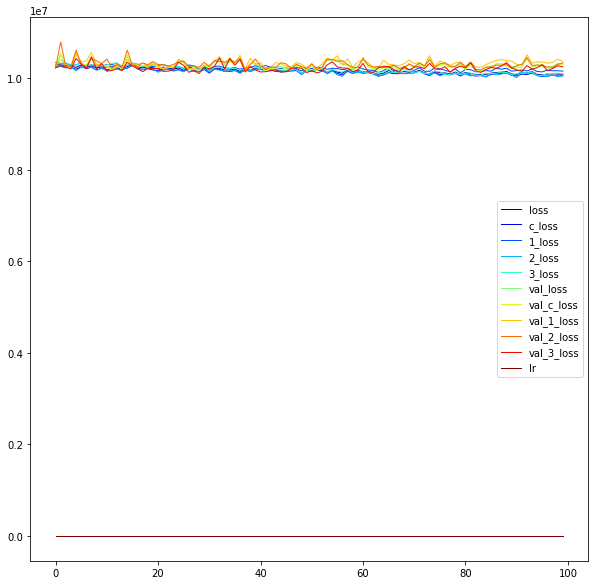

In [32]:
v.plot(figsize=(10,10),
                       rot=0, 
                       lw=1, 
                       colormap='jet',
                      )
plt.legend(fontsize=10)
plt.show()

In [47]:
p1 = np.reshape(model.predict(X_test)[0], 4520)
p2 = np.reshape(model.predict(X_test)[0], 4520)
p3 = np.reshape(model.predict(X_test)[0], 4520)
p4 = np.reshape(model.predict(X_test)[0], 4520)

In [50]:
pd.Series(p1)

0       24998830.0
1       26646724.0
2       26055534.0
3       30059006.0
4       21381996.0
           ...    
4515    17267220.0
4516    22630324.0
4517    27469846.0
4518    24740200.0
4519    26103050.0
Length: 4520, dtype: float32

In [57]:
(p1 - p2).sum()

0.0

In [55]:
pd.concat([pd.Series(p1),pd.Series(p2),pd.Series(p3),pd.Series(p4)], axis=1)

,0,1,2,3
0,24998830.0,24998830.0,24998830.0,24998830.0
1,26646724.0,26646724.0,26646724.0,26646724.0
2,26055534.0,26055534.0,26055534.0,26055534.0
3,30059006.0,30059006.0,30059006.0,30059006.0
4,21381996.0,21381996.0,21381996.0,21381996.0
...,...,...,...,...
4515,17267220.0,17267220.0,17267220.0,17267220.0
4516,22630324.0,22630324.0,22630324.0,22630324.0
4517,27469846.0,27469846.0,27469846.0,27469846.0
4518,24740200.0,24740200.0,24740200.0,24740200.0


In [97]:
sample_submission.to_csv('Submission', index=False)

In [100]:
pd.DataFrame(X_rolling[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-2.051017,73.864767,0.042132,533.480000,278.872929,93.720306,0.758839,672.429893,-0.039025,0.409666,-0.137840,3.600014,1160.782120,339.984852,0.675964,2530.0
1,4.484242,31.105837,0.349309,749.320000,639.805111,226.251348,1.464468,1540.247309,-0.000563,0.260151,0.006572,2.953706,3395.820453,1332.646455,1.745468,9860.0
2,3.064216,62.863276,-0.032905,455.233333,273.500117,77.821094,1.027161,629.952787,0.024439,0.323952,-0.153320,2.778035,1318.405810,355.758289,0.868109,2866.0
3,2.073249,55.248719,-0.033467,459.943333,375.919378,59.790868,0.820511,597.099285,0.024409,0.278691,-0.196769,3.089971,1925.714988,313.347975,0.579078,2960.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
5,-9.635820,181.516118,0.114508,1260.961055,631.757167,234.839660,0.684545,1245.188937,-0.051769,0.404505,0.054930,3.618696,2617.543808,703.485396,0.488627,4994.0
6,8.212379,118.200792,0.064503,1072.546667,487.159810,145.070628,0.759572,998.793702,0.032788,0.330709,0.072773,3.544767,2308.466676,648.420154,0.942997,4869.0
7,2.275686,158.729713,0.417880,1781.240000,579.772863,165.848399,0.783158,1056.216495,-0.003079,0.303328,-0.254950,2.809450,2720.525008,611.970920,0.584613,4943.0
8,1.541362,47.759640,-0.160323,813.586667,362.893703,69.631461,1.124021,520.377837,-0.006494,0.221197,-0.364209,2.766877,1970.546624,382.542748,0.650790,3768.0
9,2.993027,129.640231,-0.122649,1223.543333,564.460497,147.225795,0.794522,1163.703479,-0.000297,0.335405,0.086086,3.115131,2571.120398,597.846909,0.916266,5517.0


In [86]:
model.compile(optimizer=Adam(0.0015), loss='mae',)

hist = model.fit(X_rolling, y, epochs= 300, batch_size=32,
                 callbacks=[ReduceLROnPlateau(monitor='c_loss', factor=0.9, patience=10, verbose=1, min_lr=0)],
                  verbose=True,
                  validation_split=0.33,
                  shuffle=True) 

Epoch 1/300
93/93 [==============================] - 2s 21ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 2/300
93/93 [==============================] - 1s 11ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 3/300
93/93 [==============================] - 1s 10ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 4/300
93/93 [==============================] - 1s 10ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_loss: nan - 3_loss: nan - val_loss: nan - val_c_loss: nan - val_1_loss: nan - val_2_loss: nan - val_3_loss: nan
Epoch 5/300
93/93 [==============================] - 1s 11ms/step - loss: nan - c_loss: nan - 1_loss: nan - 2_lo

KeyboardInterrupt: 